<a href="https://colab.research.google.com/github/leonado10000/meow-meow/blob/main/Rahul_Jangra_Faster_RCNN_MobileNetV3_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Object Detection using PyTorch Faster R-CNN MobileNetV3](https://debuggercafe.com/object-detection-using-pytorch-faster-r-cnn-mobilenetv3)
![](https://debuggercafe.com/wp-content/uploads/2021/03/Object-Detection-using-PyTorch-Faster-R-CNN-MobileNetV3-copy-e1617153888534.jpg)

## <font color="green">Make sure that GPU is enabled before moving ahead.</font>

## Download the Input File

In [ ]:
import requests
url = "https://drive.google.com/uc?id=140fl292Ofs6tmEJzIFUPGo97AdIIO3vi&export=download"
r = requests.get(url)
with open('input.zip', 'wb') as f:
    f.write(r.content)

In [ ]:
!unzip input.zip

Archive:  input.zip
   creating: input/
  inflating: input/image_2.jpg       
  inflating: input/image_1.jpg       
  inflating: input/video_1.mp4       
  inflating: input/video_2.mp4       


## Setup

In [ ]:
!mkdir outputs

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = 21, 18

## COCO Names Python File

In [ ]:
%%writefile coco_names.py
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


Writing coco_names.py


## Detection Utility Script

In [ ]:
%%writefile detect_utils.py
import torchvision.transforms as transforms
import cv2
import numpy as np

from coco_names import COCO_INSTANCE_CATEGORY_NAMES as coco_names

# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

# define the torchvision image transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

def predict(image, model, device, detection_threshold):
    # transform the image to tensor
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    outputs = model(image) # get the predictions on the image

    # get all the predicited class names
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]

    # get score for all the predicted objects
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()

    # get all the predicted bounding boxes
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)

    return boxes, pred_classes, outputs[0]['labels']

def draw_boxes(boxes, classes, labels, image):
    image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return image


Writing detect_utils.py


## Object Detection in Images

In [ ]:
%%writefile detect_img.py
import torchvision
import torch
import argparse
import cv2
import detect_utils

from PIL import Image

# construct the argument parser
parser = argparse.ArgumentParser()
parser.add_argument('-i', '--input', help='path to input image/video')
args = vars(parser.parse_args())

# define the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the model
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
# load the model on to the computation device
model.eval().to(device)

# read the image and run the inference for detections
image = Image.open(args['input'])
boxes, classes, labels = detect_utils.predict(image, model, device, 0.7)
image = detect_utils.draw_boxes(boxes, classes, labels, image)
# cv2.imshow('Image', image)
save_name = f"{args['input'].split('/')[-1].split('.')[0]}"
cv2.imwrite(f"outputs/{save_name}.jpg", image)
# cv2.waitKey(0)

Writing detect_img.py


In [ ]:
!python detect_img.py --input input/image_1.jpg
!python detect_img.py --input input/image_2.jpg

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100% 74.2M/74.2M [00:02<00:00, 32.2MB/s]


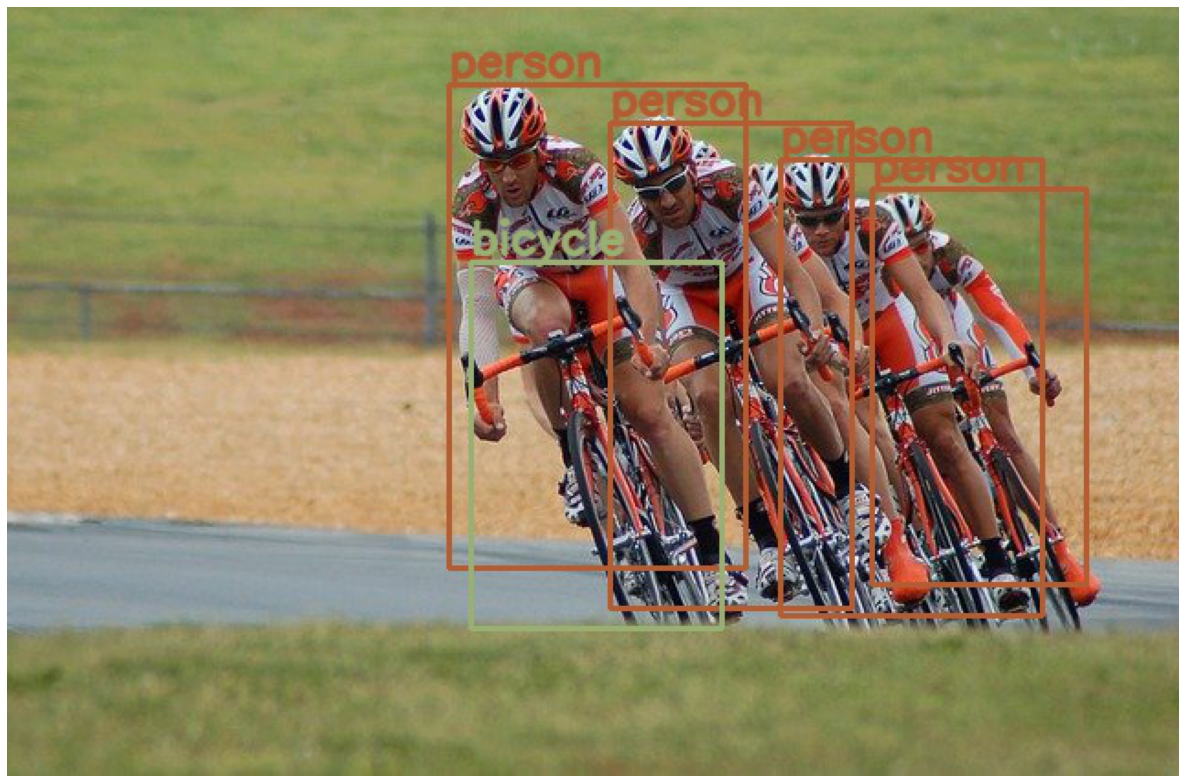

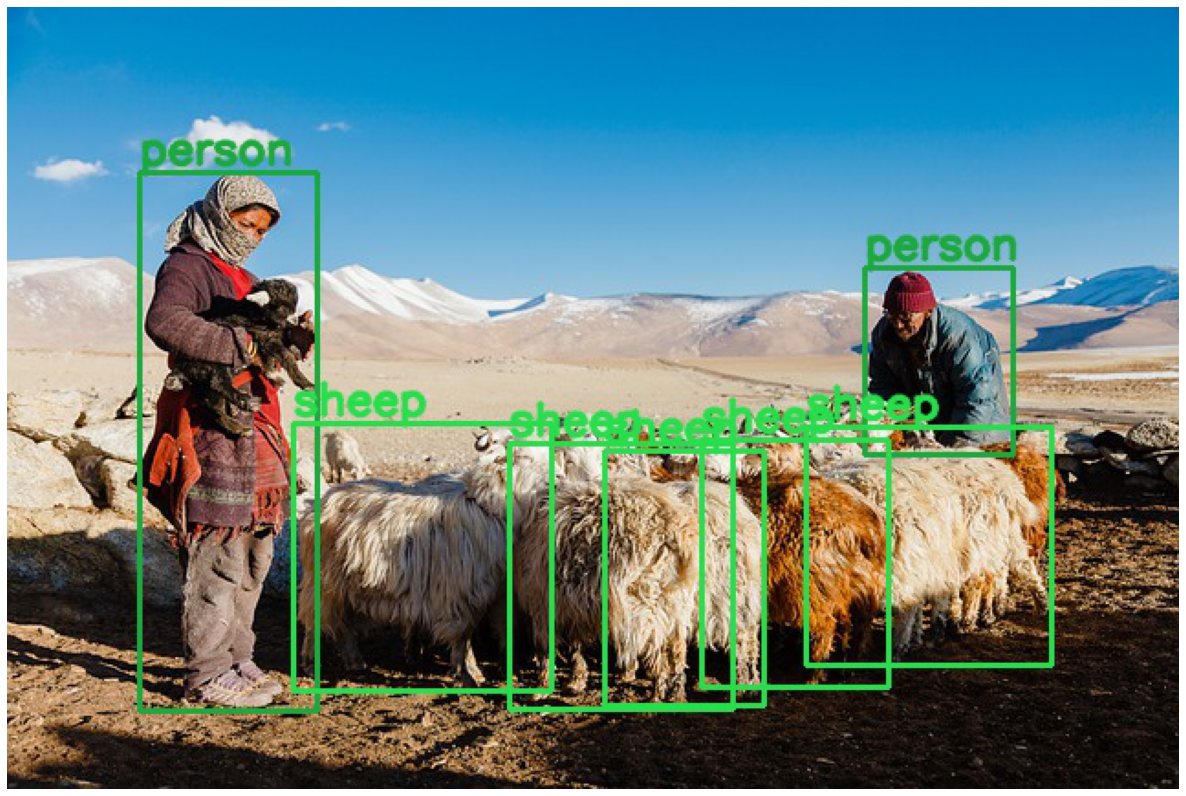

In [ ]:
image_1 = plt.imread('outputs/image_1.jpg')
image_2 = plt.imread('outputs/image_2.jpg')

plt.imshow(image_1)
plt.axis('off')
plt.show()

plt.imshow(image_2)
plt.axis('off')
plt.show()

## Object Detection in Videos

### <font color="red">Visualization of videos is not very well supported on Colab. After detection in videos, you can download the outputs and visualize them on your machine.</font>

In [ ]:
%%writefile detect_vid.py
import torchvision
import cv2
import torch
import argparse
import time
import detect_utils

# construct the argument parser
parser = argparse.ArgumentParser()
parser.add_argument('-i', '--input', help='path to input video')
args = vars(parser.parse_args())

# define the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the model
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
# load the model onto the computation device
model = model.eval().to(device)

cap = cv2.VideoCapture(args['input'])

if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')

# get the frame width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

save_name = f"{args['input'].split('/')[-1].split('.')[0]}"
# define codec and create VideoWriter object
out = cv2.VideoWriter(f"outputs/{save_name}.mp4",
                      cv2.VideoWriter_fourcc(*'mp4v'), 30,
                      (frame_width, frame_height))

frame_count = 0 # to count total frames
total_fps = 0 # to get the final frames per second

# read until end of video
while(cap.isOpened()):
    # capture each frame of the video
    ret, frame = cap.read()
    if ret == True:
        # get the start time
        start_time = time.time()
        with torch.no_grad():
            # get predictions for the current frame
            boxes, classes, labels = detect_utils.predict(frame, model, device, 0.7)

        # draw boxes and show current frame on screen
        image = detect_utils.draw_boxes(boxes, classes, labels, frame)

        # get the end time
        end_time = time.time()
        # get the fps
        fps = 1 / (end_time - start_time)
        # add fps to total fps
        total_fps += fps
        # increment frame count
        frame_count += 1
        print(f"Frame counter: {frame_count}, FPS: {fps}")
        # write the FPS on the current frame
        cv2.putText(image, f"{fps:.3f} FPS", (15, 30), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 255, 0), 2)
        # press `q` to exit
        wait_time = max(1, int(fps/4))
        # convert from BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # cv2.imshow('image', image)
        out.write(image)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break

    else:
        break

# release VideoCapture()
cap.release()
# close all frames and video windows
cv2.destroyAllWindows()

# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")


Writing detect_vid.py


In [ ]:
!python detect_vid.py --input input/video_1.mp4

Frame counter: 1, FPS: 7.335443679978174
Frame counter: 2, FPS: 8.29878198380727
Frame counter: 3, FPS: 8.818955384870932
Frame counter: 4, FPS: 9.23302338686954
Frame counter: 5, FPS: 9.802776083333917
Frame counter: 6, FPS: 9.881063609742768
Frame counter: 7, FPS: 10.65699120620571
Frame counter: 8, FPS: 10.725968054582372
Frame counter: 9, FPS: 10.826133641694888
Frame counter: 10, FPS: 10.809003241950531
Frame counter: 11, FPS: 10.538081575019975
Frame counter: 12, FPS: 10.213344567035739
Frame counter: 13, FPS: 10.827754629988176
Frame counter: 14, FPS: 10.920675918452366
Frame counter: 15, FPS: 10.462246101886011
Frame counter: 16, FPS: 10.93365727006835
Frame counter: 17, FPS: 10.795371247374707
Frame counter: 18, FPS: 10.96157454715566
Frame counter: 19, FPS: 10.828761004827925
Frame counter: 20, FPS: 10.891099495472757
Frame counter: 21, FPS: 10.817645359633557
Frame counter: 22, FPS: 10.958252450013456
Frame counter: 23, FPS: 11.006534163968153
Frame counter: 24, FPS: 10.9961

In [ ]:
!python detect_vid.py --input input/video_2.mp4

Frame counter: 1, FPS: 7.03532166567703
Frame counter: 2, FPS: 7.639661431248942
Frame counter: 3, FPS: 8.066170885041357
Frame counter: 4, FPS: 8.550694973925737
Frame counter: 5, FPS: 9.019659454042639
Frame counter: 6, FPS: 9.538796024652612
Frame counter: 7, FPS: 9.477946277452755
Frame counter: 8, FPS: 9.878806150135665
Frame counter: 9, FPS: 10.095809363340956
Frame counter: 10, FPS: 10.254771276985894
Frame counter: 11, FPS: 9.748074464870895
Frame counter: 12, FPS: 10.013641822188374
Frame counter: 13, FPS: 10.13474317029677
Frame counter: 14, FPS: 10.003348517732357
Frame counter: 15, FPS: 10.045226587983963
Frame counter: 16, FPS: 9.928380707103225
Frame counter: 17, FPS: 10.189822091896108
Frame counter: 18, FPS: 9.923565221300285
Frame counter: 19, FPS: 9.944811953774439
Frame counter: 20, FPS: 9.949199662216655
Frame counter: 21, FPS: 10.083285653154345
Frame counter: 22, FPS: 10.156978602632776
Frame counter: 23, FPS: 9.894630063435221
Frame counter: 24, FPS: 10.025010516

In [ ]:
from google.colab import files

!zip -r outputs outputs

  adding: outputs/ (stored 0%)
  adding: outputs/video_2.mp4 (deflated 1%)
  adding: outputs/video_1.mp4 (deflated 1%)
  adding: outputs/image_2.jpg (deflated 1%)
  adding: outputs/image_1.jpg (deflated 2%)


In [ ]:
files.download('outputs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>